In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('NBA_Team_Data_18-19.csv')

In [3]:
df.head()

,Team,Match Up,Game Date,Season,W/L,MIN,PTS,FGM,FGA,FG%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,PF
0,MEM,MEM vs. GSW,04/10/2019,NaN,W,240,132,48,98,49.0,...,18,83.3,15,34,49,25,9,0,11,18
1,GSW,GSW @ MEM,04/10/2019,NaN,L,240,117,46,92,50.0,...,14,85.7,9,30,39,32,3,5,14,17
2,ORL,ORL @ CHA,04/10/2019,NaN,W,240,122,48,88,54.5,...,20,75.0,9,30,39,24,5,2,6,19
3,CHA,CHA vs. ORL,04/10/2019,NaN,L,240,114,41,78,52.6,...,27,88.9,4,28,32,21,3,4,8,14
4,MIN,MIN @ DEN,04/10/2019,NaN,L,240,95,39,91,42.9,...,6,66.7,7,34,41,24,6,0,10,22


**Data Cleaning**

As you can see above, our dataset is fairly clean in that our data is recorded with a consistent format.  Lets first check for any null values in our data. This is important because we cannot generate a model with null values.

Hint: use .isnull() and .sum() to find the sum of null values in a given dataframe.

In [4]:
# Output a series with the column names of our dataframe and the sum of their null values
df.isnull().sum()  

Team            0
Match Up        0
Game Date       0
Season       2460
W/L             0
MIN             0
PTS             0
FGM             0
FGA             0
FG%             0
3PM             0
3PA             0
3P%             0
FTM             0
FTA             0
FT%             0
OREB            0
DREB            0
REB             0
AST             0
STL             0
BLK             0
TOV             0
PF              0
dtype: int64

The 'Season' column is the only column with null values.  All values are null, so we will drop the column.

In [5]:
df = df.drop('Season', axis=1)

In [6]:
df.dtypes

Team          object
Match Up      object
Game Date     object
W/L           object
MIN            int64
PTS            int64
FGM            int64
FGA            int64
FG%          float64
3PM            int64
3PA            int64
3P%          float64
FTM            int64
FTA            int64
FT%          float64
OREB           int64
DREB           int64
REB            int64
AST            int64
STL            int64
BLK            int64
TOV            int64
PF             int64
dtype: object

Next, lets split our dataset into its features, X, and the label, y. Remember that our label is whether or not a team has won the game, this is in the 'W/L' column.

In [7]:
# X should equal all of columns that are not 'W/L'
X = df.drop('W/L', axis=1)
# Y should equal the 'W/L' column
y = df['W/L']

**Exploratory Data Analysis**

This section will get us more familiar with our dataset, as well as help with feature selection later on. In the cell below, we have found the indices of wins and losses, respectively.

Using these indices, we will compare the distribution of the same variables when a team wins versus when they lose.

In [8]:
wins = y[y=="W"].index
losses = y[y=="L"].index

Generate at least 3 sets of histograms, one set for each of the following columns in X: 'PTS', 'REB', and 'TOV'.  Each set should have two histograms, one filtered by when a team wins, and another filtered by when a team loses.

Note: Your first plot will show up as blue, your second will be orange.

Hint: Use .loc to select certain rows

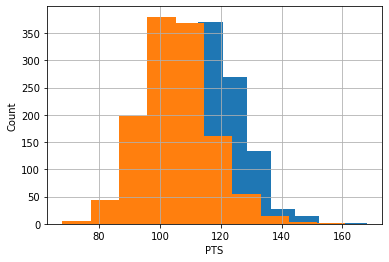

In [9]:
plt.xlabel("PTS") # Fill this in with the name of column you are plotting on the x-axis
plt.ylabel("Count") # The y-axis of a histogram should always be count, unless you are making a density plot

### Plot two histograms of your target column: one filtered by wins and one filtered by losses

X.loc[wins]["PTS"].hist()
X.loc[losses]["PTS"].hist()

In [10]:
X.columns

Index(['Team', 'Match Up', 'Game Date', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%',
       '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF'],
      dtype='object')

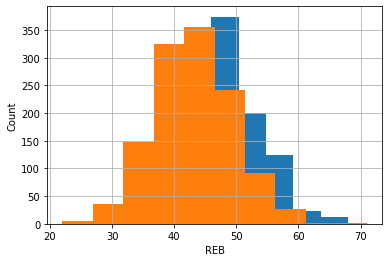

In [11]:
plt.xlabel("REB") # Fill this in with the name of column you are plotting on the x-axis
plt.ylabel("Count") # The y-axis of a histogram should always be count, unless you are making a density plot

### Plot two histograms of your target column: one filtered by wins and one filtered by losses

X.loc[wins]["REB"].hist()
X.loc[losses]["REB"].hist()

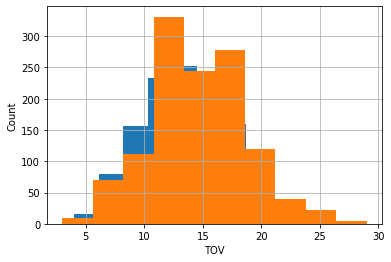

In [12]:
plt.xlabel("TOV") # Fill this in with the name of column you are plotting on the x-axis
plt.ylabel("Count") # The y-axis of a histogram should always be count, unless you are making a density plot

### Plot two histograms of your target column: one filtered by wins and one filtered by losses

X.loc[wins]["TOV"].hist()
X.loc[losses]["TOV"].hist()

Note that the distribution of 'TOV' is more even than the other two.  Lets look at the summary statistics for the 'TOV' column to find any difference in the distributions.

Hint: Use .describe() to generate summary statistics for a column.

In [13]:
X.loc[wins]['TOV'].describe()

count    1230.000000
mean       13.716260
std         3.786617
min         4.000000
25%        11.000000
50%        14.000000
75%        16.000000
max        25.000000
Name: TOV, dtype: float64

In [14]:
X.loc[losses]['TOV'].describe()

count    1230.000000
mean       14.449593
std         4.031041
min         3.000000
25%        12.000000
50%        14.000000
75%        17.000000
max        29.000000
Name: TOV, dtype: float64

**Feature Extraction and Engineering**

Now that we have some sense of what our data looks like and how distribution of columns differ when a team wins versus when they lose, lets try and select the most important features to predict whether or not a team will win.  Additionally, we can create derived features by forming combinations of our columns as we see fit, or turning categorical variables into vectors.

This part is pretty open-ended, but I do have some tips.  Check out the ['Four Factors of Basketball Success'](https://www.basketball-reference.com/about/factors.html) by Dean Oliver.  He gives weights to the four most important factors that lead to a team winning.  Our model will create weights for us, but the features outlined in his four factors can be derived from our dataset.

As a baseline model, try to input all quantitative columns into a kNN classifier and see what accuracy you are able to get.  Once you apply a model to all quantitative columns, come back to this part and see if you can improve your accuracy.  Machine Learning projects are an iterative process, meaning you should start with a baseline model and work your way up.

Recommendation: Try to standardize all your columns and see if that improves accuracy over non-standardization.

Finding Quantitative Columns:

The cell below provides skeleton code for finding all quantitative columns.

Hint: Use .dtype to find the datatype of a given column

In [15]:
quant_cols = []
for col in X.columns:
    if ...:
        quant_cols.append(col)

**Optional**

In the cell below, I will provide skeleton code for deriving a feature from our dataset.  In this example, we will be able to find whether a team is playing at Home or not based on the 'Match Up' column.  There are two types of outputs for this column: Case 1 -- 'Team_1 vs. Team_2' or Case 2 -- 'Team_1 @ Team_2'.  In Case 1, Team_1 is at home, whereas in Case 2, Team_1 is away.  

We will utilize One Hot Encoding to separate 'Home' and 'Away' into two separate columns.

Hint: Create a function to encode 'vs.' and '@' as 'Home' and 'Away' respectively for each row, then use df[column].apply(func) to apply your function to your Series.

Hint: Use .split() to help isolate the 'vs.' and '@' characters.

Hint: Use pd.get_dummies(df[column]) to One Hot Encode a given column.

In [16]:
def find_home_away(row):
    ### Insert code here -- function should return either 'Home' or 'Away'
    if ...:
        return 'Home'
    if ...:
        return 'Away'

In [17]:
home_away = ... # Return a Series of values that are either 'Home' or 'Away' (Hint: Use .apply)
... # One Hot Encode the 'Matchup Column' using pd.get_dummies.

In [18]:
X['Match Up'].head()

0    MEM vs. GSW
1      GSW @ MEM
2      ORL @ CHA
3    CHA vs. ORL
4      MIN @ DEN
Name: Match Up, dtype: object

This cell has skeleton code for performing Logistic Regression on each quantitative column and y. Use accuracy as a metric for determing which columns are most predictive towards success.  Feel free to use this once creating any derived features to check their effectiveness.

In [25]:
X_feat = ... # Create a feature dataframe that is a subset of X
model = ...  # Initialize a classifier such as KNN, LogisticRegression, SVC, etc...
for col in X_feat:
    ...  # fit your model to X_feat
    pred = ...  # make predictions with your model using 
    print("{}:".format(col))
    print("Total Accuracy:",sum(pred == y) / len(y))
    print()

MIN:
Total Accuracy: 0.0

PTS:
Total Accuracy: 0.0

FGM:
Total Accuracy: 0.0

FGA:
Total Accuracy: 0.0

FG%:
Total Accuracy: 0.0

3PM:
Total Accuracy: 0.0

3PA:
Total Accuracy: 0.0

3P%:
Total Accuracy: 0.0

FTM:
Total Accuracy: 0.0

FTA:
Total Accuracy: 0.0

FT%:
Total Accuracy: 0.0

OREB:
Total Accuracy: 0.0

DREB:
Total Accuracy: 0.0

REB:
Total Accuracy: 0.0

AST:
Total Accuracy: 0.0

STL:
Total Accuracy: 0.0

BLK:
Total Accuracy: 0.0

TOV:
Total Accuracy: 0.0

PF:
Total Accuracy: 0.0

Away:
Total Accuracy: 0.0

Home:
Total Accuracy: 0.0



/Users/jordanlevy/Documents/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


**Model Selection and Performance**

Once you have extracted all the features you wish to use in your Machine Learning model, it is time to select a model and test it's accuracy on unseen data.  Because we don't actually have unseen data, we will create a sample of our total dataset where we hold-out the labels.

Using sklearn's train_test_split, create a testing and training set with 33% of our data going towards our test set.  Refer to sklearn [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to implement this.

In [20]:
## Create X_train, X_test, y_train, and y_test with 33% of our total data in our test set
X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.33)

Once we have our training and testing datasets, we can initialize our classifier, fit to our training data, and make predictions on our testing data.  Pick whichever classifier you want, I have imported kNN, Logistic Regression, and SVM from sklearn.  You can find more classifiers on sklearn's website and import as you wish.

Hint: Use .fit() and .predict() after initializing the classifer

In [21]:
X_feat.columns

Index(['MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA',
       'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'Away',
       'Home'],
      dtype='object')

In [22]:
classifier = KNeighborsClassifier(5)
## Fit and predict using X_train, y_train, and X_test
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)

The baseline accuracy (using KNeighborsClassifier with k=5) was 0.73522.

In [23]:
sum(pred == y_test) / len(pred)

0.7364532019704434

**Hyperparameter Tuning**

Now that we have generated predictions and an accuracy from the model, change hyperparameters to improve model perfomance.  This may be changing the value of k for KNearestNeighbors, C for LogisticRegression and SVM, and others depending on your model.

You could loop through existing hyperparameters and output the score for each one to find the optimal hyperparameter value.

In [24]:
for k in range(1, 11):
    classifier = KNeighborsClassifier(k)
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    acc = sum(pred==y_test)/len(pred)
    print("k = {} Accuracy: {}".format(k, acc))

k = 1 Accuracy: 0.6921182266009852
k = 2 Accuracy: 0.6699507389162561
k = 3 Accuracy: 0.7278325123152709
k = 4 Accuracy: 0.7204433497536946
k = 5 Accuracy: 0.7364532019704434
k = 6 Accuracy: 0.7364532019704434
k = 7 Accuracy: 0.7487684729064039
k = 8 Accuracy: 0.7401477832512315
k = 9 Accuracy: 0.7573891625615764
k = 10 Accuracy: 0.7438423645320197


**Conclusion**

As you will see, it is fairly easy to get a score above 0.70 regardless of how much feature engineering we do or which classifier we choose.  However, we are sort of cheating in a sense, becuase we are using data from that game to predict the results of that game.

An interesting extension of this problem would be to predict who will win a game WITHOUT having any statistics present from that game.  One way to approach this problem would be to find average statistics of the team's last 5 or so games, and use that to predict their performance in the current game.

Additionally, we could find outside datasets, such as a dataset of Vegas odds for the game see who is favored to win.  The possibilities are endless as far as what features you could engineer to make more accurate predictions, as long as you have quality data and an open mind.